# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.



In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Import supplementary visualizations code visuals.py
import utilties as ut

import warnings
warnings.filterwarnings("ignore")

# magic word for producing visualizations in notebook
%matplotlib inline

# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## 1. Data Exploration and Cleaning

In this section we will explore dataset to understand shape,structure and completness. We will also perform data cleaning to make dataset suitable for preprocessing. 

In [6]:
# loading data for demographics informatio for the general population of Germany
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')

### A. Exploring Demographics data for the general population of Germany

In [90]:
azdias.shape

(891221, 366)

In [3]:
#pd.set_option('display.max_columns', 366)
pd.set_option('display.max_columns', None)

In [91]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [95]:
azdias.tail()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [195]:
# All columns name for azdias data set
# this will be useful later on to compare any missing columns in customers dataset
azdias_columns = azdias.columns

In [96]:
# number of unique value in column LNR
azdias.LNR.nunique()

891221

In [97]:
azdias.D19_LETZTER_KAUF_BRANCHE.nunique()

35

In [ ]:
azdias.KBA13_ANZAHL_PKW.nunique()

### First impression of characteristic of data files
Following are the first impression of the characteristics of data without much analysis. Basis for analysis is intuition, comparision with DIAS Attributes - Values 2017.xlsx

#### Observation 1:

1. All values in the 'LNR' column is unique. It seems this column is kind of index or serial number. Therefore, **we can delete this column**.
2. Most of the columns have numerical values except CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE, EINGEFUEGT_AM
3. Columns CAMEO_DEU_2015 and D19_LETZTER_KAUF_BRANCHE are alphanumeric
    - CAMEO_DEU_2015 is categorical value **needs encoding**
4. Column D19_LETZTER_KAUF_BRANCHE has value as name of other columns/features. **We can delete this column**    
5. I did not find description of following columns in DIAS Attributes - Values 2017.xlsx. **Therefore, delete them**.    
    - EINGEFUEGT_AM is date and time - no description 
    - EINGEZOGENAM_HH_JAHR is year - no description 
    - ALTERSKATEGORIE_FEIN seems age - no description
    
6. GEBURTSJAHR is year of birth : numeric value ( year ) **non-categorical**
7. KBA13_ANZAHL_PKW is number of car : numeric value **non-categorical**
8. MIN_GEBAEUDEJAHR year building is mentioned in the database : numeric value (year) **non-categorical**
9. Most of the columns' value is categorical


#### Corrective Actions for Observations 1:
Some columns can be deleted right way and some columns need encoding

In [56]:
#columns to delete from first impression
columns_to_delete =['LNR','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM','EINGEZOGENAM_HH_JAHR','ALTERSKATEGORIE_FEIN']

In [289]:
#columns need encoding from  first impression
columns_to_encode =['CAMEO_DEU_2015']

### B. Analysis of Attributes Info from excel  'DIAS Attributes - Values 2017.xlsx'

Unknown data or no transanction or missing values are represented by different values in the dataset like NaN, -1, 0, 9 etc. Therefore, I need to identify all possibles representation for missing values.Once correctly itentified, **these values will be replaced by NaN in the dataset**

In [98]:
# Read the DIAS Attributes - Values 2017.xlsx file
attr = pd.read_excel("DIAS Attributes - Values 2017.xlsx")

In [101]:
attr.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [102]:
# delete the "Unnamed: 0" and "Description" column. We do not need this for our analysis
attr.drop(['Unnamed: 0','Description'], axis=1, inplace = True)

In [104]:
# forward filling the missing values for 'Attribute' columns with valid data
attr['Attribute'].fillna(method = 'ffill', inplace = True)

In [105]:
attr.head(10)

,Attribute,Value,Meaning
0,AGER_TYP,-1,unknown
1,AGER_TYP,0,no classification possible
2,AGER_TYP,1,passive elderly
3,AGER_TYP,2,cultural elderly
4,AGER_TYP,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,1,< 30 years
7,ALTERSKATEGORIE_GROB,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,4,> 60 years


In [107]:
# filter the dataframe to retain only rows with 'unknow' or 'no...' or missing values
attr = attr[attr['Meaning'].str.contains('unknown|no ', na = False)]

In [108]:
attr['Meaning'].unique()

array(['unknown', 'no classification possible',
       'unknown / no main age detectable', 'no company in the building',
       'no transactions known', 'no transaction known',
       'no Online-transactions within the last 12 months',
       'almost no risk', 'no 1-2 family homes', 'no 3-5 family homes',
       'no 6-10 family homes', 'no >10 family homes', 'no preowner',
       'no small office/home office', 'no score calculated'], dtype=object)

##### Not all the texts/words above represents missing value in dataset. Upon manual verification, only following keywords in the 'Meaning' column indicates missing values. Therefore I need correction... 

In [110]:
# missing texts/words represents missing values in the dataset
Missing_words = ['unknown','no classification possible','unknown / no main age detectable',
                 'no transactions known','no transaction known','no score calculated']

In [111]:
#Recreate correct collection oftexts/words that indicate missing values along with Attributes
attr = attr[attr['Meaning'].str.contains('|'.join(Missing_words), na = False)]

In [112]:
attr['Meaning'].unique()

array(['unknown', 'no classification possible',
       'unknown / no main age detectable', 'no transactions known',
       'no transaction known', 'no score calculated'], dtype=object)

In [114]:
attr.head(15)

,Attribute,Value,Meaning
0,AGER_TYP,-1,unknown
1,AGER_TYP,0,no classification possible
5,ALTERSKATEGORIE_GROB,"-1, 0",unknown
11,ALTER_HH,0,unknown / no main age detectable
33,ANREDE_KZ,"-1, 0",unknown
40,BALLRAUM,-1,unknown
48,BIP_FLAG,-1,unknown
51,CAMEO_DEUG_2015,-1,unknown
105,CAMEO_DEUINTL_2015,-1,unknown
131,CJT_GESAMTTYP,0,unknown


#### Create a new dataframe  with name of the column in the dataset and its corresponding missing value representtaion.

In [115]:
#create a final collection of values indicating missing values
# AGER_TYP has two separe rows indicating different separate values for missing values. There I need to combine two values in one
new_value= []
for attribute in attr['Attribute'].unique():
    #print(attribute)
    val = attr.loc[attr['Attribute'] == attribute,'Value'].astype(str).str.cat(sep=',')
    val = val.split(',')
    new_value.append(val)

In [117]:
#create a new dataframe table that will help me replace misssing value with NaN
Attributes = pd.concat([pd.Series(attr['Attribute'].unique()),pd.Series(new_value)],axis = 1)
Attributes.columns =['Attribute','Missing_rep']

In [118]:
Attributes.head()

,Attribute,Missing_rep
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


In [120]:
idx = Attributes.index[Attributes['Attribute'] == 'ANREDE_KZ']
idx

Int64Index([3], dtype='int64')

In [121]:
Attributes.loc[idx,'Missing_rep'].iloc[0]

['-1', ' 0']

### C. Cleaning of insignificant features and data instances
In ealrier two sections we have explore the data to understand its characterstics and also prepared ourself with all the information to perform necessary cleaning of data and information not required for our machine learning task

#### Replace missing values  with NaN in the azdias dataset:
We find out the values that represents Missing data for the feature from the newly created 'Attributes' table and match values from azdias dataset. Then replace them with np.nan

In [122]:
%%timeit

for attribute in Attributes['Attribute']:
    if attribute in azdias.columns:
        #index of Attributes info table for the matching table, so that we can find corresponding missing representation
        idx = Attributes.index[Attributes['Attribute'] == attribute]
        miss_rep = Attributes.loc[idx,'Missing_rep'].iloc[0]
        #idx_az= azdias.loc[:, attribute].isin(miss_rep)
        #azdias.loc[idx_az, attribute] = np.NaN
        azdias[attribute].mask(azdias.loc[:, attribute].isin(miss_rep),np.NaN,inplace=True)
    else:
        continue 

6.15 s ± 317 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [123]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

#### Find percentage of missing values for each Feature/Column

In [153]:
# find total number of missing values for each column and store it into pandas series
null_data = azdias.isnull().sum()

In [154]:
type(null_data)

pandas.core.series.Series

In [128]:
null_data.head()

LNR                 0
AGER_TYP       685843
AKT_DAT_KL      73499
ALTER_HH       310267
ALTER_KIND1    810163
dtype: int64

In [130]:
#create a new dataframe with column name and corresponding total number and percentage of null values
df_null = pd.DataFrame({ 'Colums_Name' : null_data.index, 'Null_Values' : null_data.values, 
                        'Null_Percentage': null_data.values*100/len(azdias) })

In [131]:
df_null.head()

,Colums_Name,Null_Values,Null_Percentage
0,LNR,0,0.000000
1,AGER_TYP,685843,76.955435
2,AKT_DAT_KL,73499,8.247000
3,ALTER_HH,310267,34.813699
4,ALTER_KIND1,810163,90.904837


In [132]:
# Sorting column with decsending order percentage of missing values limited to 17% for easy visualization  
df_null[df_null.Null_Percentage>17].sort_values(by = 'Null_Percentage',ascending = False)

,Colums_Name,Null_Values,Null_Percentage
7,ALTER_KIND4,890016,99.864792
349,TITEL_KZ,889061,99.757636
6,ALTER_KIND3,885051,99.307691
76,D19_TELKO_ONLINE_DATUM,883018,99.079577
34,D19_BANKEN_OFFLINE_DATUM,871535,97.791120
5,ALTER_KIND2,861722,96.690047
71,D19_TELKO_ANZ_12,857990,96.271295
28,D19_BANKEN_ANZ_12,831734,93.325225
72,D19_TELKO_ANZ_24,826208,92.705176
87,D19_VERSI_ANZ_12,821289,92.153237


In [134]:
# find name of the columns that has more than 20% of missing values and store in variable
col_del_20NaN= list(df_null.Colums_Name[df_null.Null_Percentage>20])

In [142]:
col_del_20NaN

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [19]:
len(col_del_20NaN)

42

In [20]:
# add these columns name into columns_to_delete list and remove the repetition from previous list 'columns_to_delete'
# difference between append() and extend() : https://www.geeksforgeeks.org/append-extend-python/
#columns_to_delete.extend(col_del_20NaN)

columns_to_delete = list(set(columns_to_delete) | set(col_del_20NaN)) 

In [23]:
len(columns_to_delete)

45

In [147]:
#Final list of columns to be deleted
columns_to_delete

['D19_TELKO_ONLINE_DATUM',
 'EINGEFUEGT_AM',
 'D19_SOZIALES',
 'D19_BANKEN_ANZ_12',
 'EINGEZOGENAM_HH_JAHR',
 'D19_VERSAND_ANZ_24',
 'D19_BANKEN_OFFLINE_DATUM',
 'LNR',
 'EXTSEL992',
 'ALTERSKATEGORIE_FEIN',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_ANZ_12',
 'D19_VERSI_ANZ_24',
 'D19_KONSUMTYP',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_DATUM',
 'D19_LOTTO',
 'KK_KUNDENTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'ALTER_KIND1',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_BANKEN_ANZ_24',
 'D19_VERSI_ONLINE_QUOTE_12',
 'D19_BANKEN_DATUM',
 'ALTER_KIND2',
 'D19_VERSI_ANZ_12',
 'D19_VERSAND_ANZ_12',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'AGER_TYP',
 'ALTER_KIND4',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'KBA05_BAUMAX',
 'D19_TELKO_OFFLINE_DATUM',
 'ALTER_HH',
 'D19_VERSAND_DATUM',
 'ALTER_KIND3',
 'TITEL_KZ']

In [155]:
# Cleaning up memory 
null_data = None
Attributes =None
df_null = None

#### Observation 2 and Corrective Actions:
1. We have already collected 5 columns for deletion based on first impression in part 1 of analysis ( Refere **Finding1** section).Then we replaced all the unknown values with NaN. We further found that there are 42 features having more than 20% missing values. In order to reduce noice in the dataset we will delete features with more than 20% missing values.

2. Rest of the columns have missing values raning from 17% to 0%. Deleting these columns might result in significant data loss.

Therefore, for rest of the column we will **drop only rows having certain number of missing values (dropna) and rest Impute**

In [58]:
# Drop feature having more than 20% missing values (~ 42) plus columns from initial analysis (~5) 
azdias.drop(columns_to_delete, axis =1, inplace = True)

In [59]:
azdias.shape

(891221, 321)

#### Observation : Total number of feature has come down from 366 to 321 .i.e around 45 features are deleted from the dataset. This will significantly reduce noice in the dataset

## 2. Data Preprocessing

In [148]:
azdias.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST

In [149]:
#Descrptive stat of the data 
azdias.describe()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX

In [150]:
azdias.shape[1]

321

In [151]:
azdias.count(axis = 1)[0:10]

0     85
1    321
2    321
3    317
4    321
5    321
6    321
7    321
8    321
9    321
dtype: int64

In [157]:
# missing values for each rows
rows_nan= azdias.shape[1]- azdias.count(axis = 1)

In [160]:
# Descrptive stat for missing value for rows
rows_nan.describe()

count    891221.000000
mean         30.645355
std          73.092797
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max         246.000000
dtype: float64

In [158]:
# Rows having more than 100 missing values 
rows_nan[rows_nan>100].sort_values(ascending= False)

472919    246
732775    244
643174    244
15680     243
15284     243
451655    243
281305    243
826869    243
469054    243
212053    243
80444     243
537799    243
57866     242
413815    242
95888     242
522174    242
37310     242
255742    242
418780    242
350182    242
44204     242
629707    242
546758    242
23667     242
739769    242
347712    242
3288      242
716386    242
500464    242
438456    242
         ... 
857259    116
267676    116
421073    116
549581    116
826160    116
267677    116
174290    116
188454    116
517599    116
635498    116
641102    116
594732    116
189277    116
96872     116
328049    116
699191    116
341105    116
446378    116
873937    116
97327     116
217352    116
601102    116
815506    116
804670    116
631766    116
801681    116
503056    116
679091    116
440518    103
698466    101
Length: 105802, dtype: int64

In [256]:
# Rows having more than 10 missing values 
rows_nan[rows_nan>10].sort_values(ascending= False)

472919    246
643174    244
732775    244
281305    243
826869    243
15680     243
451655    243
469054    243
15284     243
537799    243
212053    243
80444     243
57866     242
55664     242
500464    242
522174    242
5099      242
42951     242
255742    242
716386    242
629707    242
350182    242
140317    242
332962    242
373501    242
44204     242
228624    242
37310     242
3288      242
438456    242
         ... 
175407     11
23516      11
27662      11
776599     11
552251     11
716933     11
400395     11
179619     11
372280     11
425764     11
333321     11
751032     11
161565     11
656478     11
46283      11
445583     11
19348      11
182308     11
46390      11
213674     11
367324     11
197730     11
17702      11
423046     11
815740     11
251238     11
751259     11
865495     11
262930     11
297703     11
Length: 158732, dtype: int64

#### Observation 3 and Corrective Actions:
After deleteting 45 feature/Columns having more than 20% missing values plus other criteria, we analysed missing values for each row for remaining columns. We found that on and average there is 30 missing values for each row with 73 standard deviation. Maximum missing values for row is 246. 

For further processing of data, we have following options

-  If we decide to drop rows with more than 10 missing values) then **we will lose 158732 out of total 891221 rows i.e. ~ 18 % of the rows**. This is huge data loss  
-  If we decide to delete rows with more than 100 missing values, **we will lose 105802 rows out of total 891221 row i.e 11.8% of rows**.

Loosing 11.8% of data shall be acceptable. And this will additionally reduce further noise in the dataset .

In [165]:
# dropping rows with more than 100 number of missing values
azdias.drop(azdias.index[rows_nan > 100], axis=0, inplace = True)
azdias.shape

(785419, 321)

In [166]:
azdias.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST

In [167]:
azdias.tail()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST

#### Observation 4
1. Now Dataset looks much cleaner with very few NaN values. We will proceed with further data processing
2. **Most of the features are Categorical except few which are numerical as mentioned below**. For machine learning problem, Categorical data need to be encoded numerically.Two features 'CAMEO_DEU_2015' and 'OST_WEST_KZ' are not encoded numerically. Therefore, we need these to be encoded with number

In [3]:
#list of numerical columns
numerical_col =['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','MIN_GEBAEUDEJAHR','GEBURTSJAHR','KBA13_ANZAHL_PKW']

#list of columns for encoding
columns_to_encode = ['CAMEO_DEU_2015','OST_WEST_KZ']

#### Encoding two columns mentioned above : 'CAMEO_DEU_2015' and 'OST_WEST_KZ'
1. 'OST_WEST_KZ' has two categories ( 'W' and 'O'). Therefore, these values will replaced with '0' and '1'
2. 'CAMEO_DEU_2015' has 44 category. I have decided to go ahead with "Label Encoding".This may lead to priority issue in training of data sets as high value is considered to have high priority than label with lower value. In our dataset we have already many other features with higher cordinality. Therefore, by this I am not introducing any new issues anyway. If I go with one hot encoding, then this will generate new features equivalent to cardinality number.

Therefore, we have two options - (a) we delete features with very high cardinality (b) keep them as-it-is, keep watch on training performance and decide later.

I have decided to **not to delete features with high cardinality.** Rather perform label encoding

Ref : https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/

In [168]:
# as 'OST_WEST_KZ' has two values 'W' and 'O', replacing these with '0' and '1' correspondengly 
azdias['OST_WEST_KZ'].replace(['W', 'O'], [0, 1], inplace=True)

In [169]:
azdias['OST_WEST_KZ'].head()

1    0
2    0
3    0
4    0
5    0
Name: OST_WEST_KZ, dtype: int64

In [170]:
azdias['CAMEO_DEU_2015'].value_counts()

6B    56079
8A    51918
4C    47265
2D    34718
3C    34379
7A    34003
3D    33971
8B    32849
4A    32657
8C    30754
9D    28090
9B    27288
9C    24577
7B    24134
9A    20394
2C    19192
8D    17421
6E    15970
2B    15302
5D    14692
6C    14648
2A    13114
5A    11878
1D    11845
1A    10722
5B    10242
3A    10093
5C     9780
4B     8938
7C     8900
4D     8493
3B     6992
6A     6709
6D     6018
9E     5947
6F     5338
4E     5267
7D     5199
1E     5009
7E     4581
1C     4266
5F     4237
1B     4028
5E     3524
XX      347
Name: CAMEO_DEU_2015, dtype: int64

In [265]:
# CAMEO_DEU_2015 has value as 'XX'.We need to replace 'XX' and 'X' with np.nan as missing values
#replace 'XX' with np.nan
azdias['CAMEO_DEU_2015'].replace('XX', np.nan, inplace= True)

In [267]:
# label encoding CAMEO_DEU_2015
le = preprocessing.LabelEncoder()
azdias['CAMEO_DEU_2015'] = le.fit_transform(azdias['CAMEO_DEU_2015'].astype(str))

In [173]:
azdias['CAMEO_DEU_2015'].value_counts()

18    56079
29    51918
7     47265
43    34718
3     34379
24    34003
4     33971
30    32849
5     32657
31    30754
37    28090
35    27288
36    24577
25    24134
33    20394
42    19192
32    17421
21    15970
41    15302
14    14692
19    14648
40    13114
10    11878
23    11845
0     10722
11    10242
44    10093
13     9780
6      8938
26     8900
8      8493
2      6992
17     6709
20     6018
38     5947
22     5338
9      5267
27     5199
34     5009
28     4581
12     4266
16     4237
1      4028
39     3998
15     3524
Name: CAMEO_DEU_2015, dtype: int64

#### Identify Categorical and Numerical feature  and create two separate lists
Numerical features are already stored into the list numerical_col. Rest of the features/Columns are categorical. Create list for all the numerical features and store in a list 

In [60]:
numerical_col =['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','MIN_GEBAEUDEJAHR','GEBURTSJAHR','KBA13_ANZAHL_PKW']

In [61]:
#identify categorical feature and store in the list 'categorical_col'
categorical_col =[]
for col in azdias.columns:
    if col not in numerical_col:
        categorical_col.append(col)

In [62]:
# find number of columns for each data category
len(categorical_col), len(numerical_col), len(azdias.columns)

(314, 7, 321)

### Imputation Strategy

#### Imputation of Categorical Values

There are various way we can Imput missing value for the categorical variable :

1. Imputation of NaN values with mode. This may introduce bias. But it is most commonly used for categorical value
2. NaN values as a separate category by itself. 
3. Prediction models: Create a predictive model using logistic regression and ANOVA. Fill the missing value with predicted vaue

I have decided to go with **imputation with Mode for categorical variable**

#### Imputation of Numerical  Values

For Imputation of missing values for numerical variable , we will use **imputation with median**. Reason is : in dataset there are for number of people and year etc for which fraction value might not make sense. We have odd number of row. It will generate integar median. ( Even if few features generate fraction, we are going to ignore these. Because, though in reality fraction of people and year does not make much sense but for out machine learning problem it will not make anu material difference) 


In [177]:
# while Imputing Categorical data, code fails due to presence of 'XX' and 'X' in some of the feature. We need to handle this

#replace 'XX' with np.nan
azdias['CAMEO_INTL_2015'].replace('XX', np.nan, inplace= True)
azdias['CAMEO_DEUG_2015'].replace('XX', np.nan, inplace= True)
azdias['CAMEO_DEUG_2015'].replace('X', np.nan, inplace= True)

In [178]:
# if I user %%timeit no vaue is return and azdias is become empty. Also imputer.fit_transform(data_cat) does not return any value

#Imputation of Categorical Values and create a separate dataframe with imputed Categorical data
start_time = time.time()

data_cat = azdias[categorical_col]
imputer = preprocessing.Imputer(missing_values='NaN', strategy='most_frequent')
#imputer.fit_transform(data_cat)
azdias_cat = pd.DataFrame(imputer.fit_transform(data_cat), columns = data_cat.columns)

elapstime = time.time() - start_time 
print(elapstime)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


85.94157218933105


In [179]:
azdias_cat.shape

(785419, 314)

In [180]:
# Verify whether still there are any NaN remaining in the dataset
azdias_cat.isnull().sum()

AKT_DAT_KL                    0
ANZ_KINDER                    0
ANZ_STATISTISCHE_HAUSHALTE    0
ARBEIT                        0
BALLRAUM                      0
CAMEO_DEU_2015                0
CAMEO_DEUG_2015               0
CAMEO_INTL_2015               0
CJT_GESAMTTYP                 0
CJT_KATALOGNUTZER             0
CJT_TYP_1                     0
CJT_TYP_2                     0
CJT_TYP_3                     0
CJT_TYP_4                     0
CJT_TYP_5                     0
CJT_TYP_6                     0
D19_BANKEN_DIREKT             0
D19_BANKEN_GROSS              0
D19_BANKEN_LOKAL              0
D19_BANKEN_REST               0
D19_BEKLEIDUNG_GEH            0
D19_BEKLEIDUNG_REST           0
D19_BILDUNG                   0
D19_BIO_OEKO                  0
D19_BUCH_CD                   0
D19_DIGIT_SERV                0
D19_DROGERIEARTIKEL           0
D19_ENERGIE                   0
D19_FREIZEIT                  0
D19_GARTEN                    0
                             ..
SEMIO_KA

##### Observation : All Missing values are imputed

In [183]:
#Imputation of Numerical Values and create separate dataframe with numerical data

data_num = azdias[numerical_col]
imputer_num = preprocessing.Imputer(missing_values='NaN', strategy='median')
#imputer_num.fit_transform(data_num)
azdias_num = pd.DataFrame(imputer_num.fit_transform(data_num), columns = data_num.columns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [184]:
azdias_num.isnull().sum()

ANZ_HAUSHALTE_AKTIV    0
ANZ_HH_TITEL           0
ANZ_PERSONEN           0
ANZ_TITEL              0
MIN_GEBAEUDEJAHR       0
GEBURTSJAHR            0
KBA13_ANZAHL_PKW       0
dtype: int64

In [185]:
# Adding both Categorical and Numerical data into single final data frame
azdias_final = pd.concat([azdias_cat,azdias_num],axis = 1, ignore_index=True)

In [186]:
azdias_final.columns = azdias_cat.columns.append(azdias_num.columns)

In [188]:
azdias_final.head()

,AKT_DAT_KL,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,RE

In [387]:
azdias_final.shape

(785419, 321)

In [389]:
azdias_final.isnull().sum()

AKT_DAT_KL                    0
ANZ_KINDER                    0
ANZ_STATISTISCHE_HAUSHALTE    0
ARBEIT                        0
BALLRAUM                      0
CAMEO_DEU_2015                0
CAMEO_DEUG_2015               0
CAMEO_INTL_2015               0
CJT_GESAMTTYP                 0
CJT_KATALOGNUTZER             0
CJT_TYP_1                     0
CJT_TYP_2                     0
CJT_TYP_3                     0
CJT_TYP_4                     0
CJT_TYP_5                     0
CJT_TYP_6                     0
D19_BANKEN_DIREKT             0
D19_BANKEN_GROSS              0
D19_BANKEN_LOKAL              0
D19_BANKEN_REST               0
D19_BEKLEIDUNG_GEH            0
D19_BEKLEIDUNG_REST           0
D19_BILDUNG                   0
D19_BIO_OEKO                  0
D19_BUCH_CD                   0
D19_DIGIT_SERV                0
D19_DROGERIEARTIKEL           0
D19_ENERGIE                   0
D19_FREIZEIT                  0
D19_GARTEN                    0
                             ..
SEMIO_RE

In [88]:
# Dumping the azdias_final dataframe to pickle object to preserve work so far
file = open("azdias_final.pickle", "wb")
pickle.dump(azdias_final, file)
file.close()

### Summary : Data Cleaning and Proprocessing on Demographics data of German Population

1. Deleted 45 no of Features/Columns based on criteria of missing values ( >20% ) and other criterias. Name of these columns are store into list 'columns_to_delete'   
2. Deleted rows having more than 100 missing values
3. Relace 'XX' and 'X' value with NaN
4. Feature 'OST_WEST_KZ' has two values 'W' and 'O', replacing these with '0' and '1' correspondengly
5. Label encoding of CAMEO_DEU_2015
6. Numerical features (stored into list 'numerical_col') are imputed with median value
7. Categorical features (stored into list 'numerical_col') are imputed with Mode i.e. 'most_frequent' value

**We need to perform same operations on demographics data for customers of a mail-order company**. For that we will create  function to perform all above mentioned tasks

### B. Exploring  demographics data for customers of a mail-order company.

In [393]:
# freeing earlier memory
customers = None 

In [5]:
# loading data for demographics informatio for customers of a mail-order company
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

In [395]:
customers.shape

(191652, 369)

In [193]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [370]:
customers.tail()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

#### Find out any feature/column not common between azdias and customer data set apart three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP')

In [360]:
# Original columns in azdias data set
len(azdias_columns)

366

In [200]:
# customer columns does not exist in azdias columns
customer_not_in_azdias = [col for col in customers.columns if col not in azdias_columns] 
customer_not_in_azdias

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

In [201]:
# azdias columns does not present in customer columns
azdias_not_in_customes = [col for col in azdias_columns if col not in customers.columns] 
azdias_not_in_customes

[]

##### comment :  Customer data has only three extra features as 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP')

#### Analyze characteristics of  three extra features ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP')

In [396]:
columns_extra = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

In [361]:
customers['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [212]:
customers['ONLINE_PURCHASE'].value_counts()

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

In [298]:
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [367]:
customers['OST_WEST_KZ'].value_counts()

W    130382
O     11343
Name: OST_WEST_KZ, dtype: int64

In [368]:
len(customers['OST_WEST_KZ'])

191652

In [369]:
customers['OST_WEST_KZ'].isnull().sum()

49927

#### Characteristic  of three extra columns and their treatment
1. All the three columns do not have any missing values. They are categorical data
2. PRODUCT_GROUP shall be label encoded .From earlier analysis of azdias data we know CAMEO_DEU_2015 is also label encoded.
2. ONLINE_PURCHASE purchase is already binary encoding.CUSTOMER_GROUP has 3 values, we will replace them with 0,1,2. From earlier analysis of azdias data we know that OST_WEST_KZ will be encoded binary 

In [292]:
columns_lbl_encod = ['PRODUCT_GROUP','CAMEO_DEU_2015']
# ONLINE_PURCHASE( MULTI_BUYER == 1, SINGLE_BUYER  ==0 )
# OST_WEST_KZ ('W' == 0,  'O' ==1)
# customers (FOOD==0, COSMETIC==1,COSMETIC_AND_FOOD==2 )
columns_bin_encod = ['CUSTOMER_GROUP', 'OST_WEST_KZ' ]

#### Analyze similiarity between azdias and customers dataset

In [291]:
# columns which contain 'X' or/and 'XX' values
columns_xxx = ['CAMEO_DEU_2015','CAMEO_INTL_2015','CAMEO_DEUG_2015']

In [399]:
for col in columns_xxx:
    
    print("{} contains {} number of X".format(col,customers[col][customers[col] =='X'].count()))
    print("{} contains {} number of XX".format(col,customers[col][customers[col] =='XX'].count()))

CAMEO_DEU_2015 contains 0 number of X
CAMEO_DEU_2015 contains 126 number of XX
CAMEO_INTL_2015 contains 0 number of X
CAMEO_INTL_2015 contains 126 number of XX
CAMEO_DEUG_2015 contains 126 number of X
CAMEO_DEUG_2015 contains 0 number of XX


##### columns having 'XX' or 'X' values which need to replace by np.nan are stored into separate list

columns_xx = ['CAMEO_DEU_2015','CAMEO_INTL_2015']

columns_x = ['CAMEO_DEUG_2015']

In [33]:
# following columns include 'XX' or 'X' values which need to replace by np.nan
columns_xx = ['CAMEO_DEU_2015','CAMEO_INTL_2015']
columns_x = ['CAMEO_DEUG_2015']

In [7]:
# Check whether three extra columns contain NaN and hence need imputation
print ( "CUSTOMER_GROUP contains {} NaN values".format(customers['CUSTOMER_GROUP'].isnull().sum()))
print ( "ONLINE_PURCHASE contains {} NaN values".format(customers['ONLINE_PURCHASE'].isnull().sum()))
print ( "PRODUCT_GROUP contains {} NaN values".format(customers['PRODUCT_GROUP'].isnull().sum()))

CUSTOMER_GROUP contains 0 NaN values
ONLINE_PURCHASE contains 0 NaN values
PRODUCT_GROUP contains 0 NaN values


####  Three extra features/columns do not contain NaN value and hence do not need Imputation

### Create Cleaning and Proprocessing Function

Based on above analysis, we are going to create three functions for cleaning and preprocessing the dataset
1. First function is for deleting columns to reduce noise in data and replacing 'XX' and 'X' values with Nan
2. Second function is deleting data rows having more than certain number of NaN values and encoding data
3. Thrid function is for Imputing

In [38]:
def clean_feature(df, col_del, col_xx, col_x):
    """
    Perform feature reduction and replacing missing values(XX and X) 
    with Nan for demographics data
    
    INPUT: 
        df: demographics DataFrame
        col_del: list of feature need to reduce
        col_xx = list of feature where 'XX' value need to replace with NaN
        col_x = list of feature where 'X' value need to replace with NaN
    OUTPUT: Cleaner demographics DataFrame
    """
    # deleting selected columns to reduce data noise
    df.drop(col_del, axis =1, inplace = True)
    
    # replacing XX values with NaN
    for c_xx in col_xx:
        df[c_xx].replace('XX', np.nan, inplace= True)
    
    # replacing XX values with NaN
    for c_x in col_x:
        df[c_x].replace('X', np.nan, inplace= True)
    
        
    # Return dataframe with reduced features
    return df

In [39]:
def clean_encode_row(df,no_of_nan, col_lbl):
    """
    Perform feature reduction by deleting row having certain number of NaN values and label encoding
    
    INPUT: 
        df: demographics DataFrame
        rows_nan: number of NaN values above which row is marked for deletion 
        col_lbl = list of feature for label encoding
        
    OUTPUT: Cleaner demographics DataFrame
    """
    # missing values for each rows
    rows_nan= df.shape[1]- df.count(axis = 1)
    
    # deleting selected rows to reduce data noise
    df.drop(df.index[rows_nan > no_of_nan], axis=0, inplace = True)
    
    #'OST_WEST_KZ' has two values 'W' and 'O', replacing these with '0' and '1' correspondengly 
    df['OST_WEST_KZ'].replace(['W', 'O'], [0, 1], inplace=True)
    
    #CUSTOMER_GROUP( MULTI_BUYER == 1, SINGLE_BUYER  ==0 )
    if 'CUSTOMER_GROUP' in df.columns:
        df['CUSTOMER_GROUP'].replace(['SINGLE_BUYER', 'MULTI_BUYER'], [0, 1], inplace=True)
    
    #PRODUCT_GROUP (FOOD==0, COSMETIC==1,COSMETIC_AND_FOOD==2 )
    if 'PRODUCT_GROUP' in df.columns:
        df['PRODUCT_GROUP'].replace(['FOOD','COSMETIC','COSMETIC_AND_FOOD'], [0, 1,2], inplace=True)
    
    # label encoding ['PRODUCT_GROUP','CAMEO_DEU_2015']
    le = preprocessing.LabelEncoder()
    for col in col_lbl:
        df[col] = le.fit_transform(df[col].astype(str))
        
    return df

In [40]:
def impute_data(df,col_cat, col_num,col_xtra):
    """
    Perform feature reduction and replacing missing values(XX and X) 
    with Nan for demographics data
    
    INPUT: 
        df: demographics DataFrame
        col_cat: list of feature for with categorical values
        col_num = list of feature for with numerical values
        col_xtra = list of extra columns
    OUTPUT: final demographics DataFrame
    """
    #adding the categorical columns with extra columns
    col_cat.extend(col_xtra)
    #Imputation of Categorical Values
    data_cat = df[col_cat]
    imputer = preprocessing.Imputer(missing_values='NaN', strategy='most_frequent')
    #imput and create a dataframe
    df_cat = pd.DataFrame(imputer.fit_transform(data_cat), columns = data_cat.columns)


    #Imputation of Numerical Values
    data_num = df[col_num]
    imputer_num = preprocessing.Imputer(missing_values='NaN', strategy='median')
    #imput and create a dataframe
    df_num = pd.DataFrame(imputer_num.fit_transform(data_num), columns = data_num.columns)

    # Adding both Categorical and Numerical data into single final data frame
    df_final = pd.concat([df_cat,df_num],axis = 1, ignore_index=True)
    df_final.columns = df_cat.columns.append(df_num.columns)
    
        
    return df_final

###  Cleaning and Proprocessing of Customer demographic informations

##### Cleaning noisy features and  replacing 'XX'/'X' values with NaN in customers dataset

In [404]:
# cleaning noisy feature and replacing 'XX'/'X' value with np.nan
customers =  clean_feature(customers, columns_to_delete , columns_xx , columns_x)

In [405]:
customers.shape

(191652, 324)

In [406]:
for col in columns_xx:
    print("{} contains {} number of XX".format(col,customers[col][customers[col] =='XX'].count()))

CAMEO_DEU_2015 contains 0 number of XX
CAMEO_INTL_2015 contains 0 number of XX


In [407]:
for col in columns_x:
    print("{} contains {} number of X".format(col,customers[col][customers[col] =='X'].count()))

CAMEO_DEUG_2015 contains 0 number of X


##### Analyze missing values in row in customers dataset

In [286]:
# missing values for each rows
rows_nan_cust= customers.shape[1]- customers.count(axis = 1)

# Descrptive stat for missing value for rows
rows_nan_cust.describe()


count    191652.000000
mean         63.618637
std         100.898686
min           0.000000
25%           0.000000
50%           0.000000
75%         218.000000
max         241.000000
dtype: float64

In [287]:
# Rows having more than 100 missing values 
rows_nan_cust[rows_nan_cust>100].sort_values(ascending= False)

56265     241
105085    241
157358    241
62537     241
75764     241
17199     241
90306     241
89983     241
136693    241
84107     241
89555     241
84401     241
124512    241
124407    241
177908    241
2794      241
58087     241
58122     241
134876    241
33815     241
74012     241
180004    241
3852      241
107961    241
150280    241
128189    241
189942    241
29119     241
117708    241
81510     241
         ... 
95972     116
77020     116
7771      116
127336    116
114112    116
59196     116
103638    116
154195    116
22561     116
104652    116
100564    116
66065     116
161308    116
635       116
67379     116
104835    116
185185    116
131657    116
17998     116
70629     116
146087    116
10759     116
185261    116
167623    116
150068    116
167409    116
7970      116
79419     116
39313     116
135635    116
Length: 51281, dtype: int64

In [289]:
# Rows having more than  missing values 
rows_nan_cust[rows_nan_cust>10].sort_values(ascending= False)

51669     241
128189    241
82091     241
81510     241
89555     241
180004    241
90306     241
2794      241
130071    241
63869     241
151013    241
58122     241
124512    241
134876    241
124407    241
105085    241
157358    241
58087     241
75764     241
89983     241
29119     241
136693    241
74012     241
33815     241
150280    241
56265     241
17199     241
159644    241
28571     241
189942    241
         ... 
15103      20
15219      20
67752      20
164357     20
164371     20
164383     20
164411     20
68589      20
68162      20
164436     20
15070      20
163544     20
163580     20
99820      20
68490      20
68487      20
129624     20
68420      20
100042     20
68395      20
68342      20
68246      20
68234      20
99984      20
100034     20
164420     20
149227     13
166099     12
17294      12
71150      12
Length: 59552, dtype: int64

##### Comments and Observations
-  If we decide to drop rows with more than 10 missing value) then **we will lose 59552 out of total 191652 rows 
-  If we decide to delete rows with more than 100 missing values, **we will lose 51281 rows out of total 191652 row 

I both case we will lose more that 1/4 of the data. In order to keep consistency with azdias dataset we will go with deletig rows having more than 100 missing values

#### Cleaning up rows with more than 100 missing values and encoding categorical data

In [408]:
customers = clean_encode_row(customers,100, columns_lbl_encod)

In [409]:
customers.shape

(140371, 324)

In [379]:
customers['CUSTOMER_GROUP'].value_counts()

1    98600
0    41771
Name: CUSTOMER_GROUP, dtype: int64

In [380]:
len(customers['CUSTOMER_GROUP'])

140371

#### Impute remaining missing values values numerrical and categorical data

In [410]:
len(categorical_col),len(numerical_col)

(314, 7)

In [411]:
customers_final = impute_data(customers,categorical_col, numerical_col, columns_extra)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [412]:
customers_final.shape

(140371, 324)

In [413]:
print ( "CUSTOMER_GROUP contains {} NaN values".format(customers_final['CUSTOMER_GROUP'].isnull().sum()))
print ( "ONLINE_PURCHASE contains {} NaN values".format(customers_final['ONLINE_PURCHASE'].isnull().sum()))
print ( "PRODUCT_GROUP contains {} NaN values".format(customers_final['PRODUCT_GROUP'].isnull().sum()))

CUSTOMER_GROUP contains 0 NaN values
ONLINE_PURCHASE contains 0 NaN values
PRODUCT_GROUP contains 0 NaN values


In [414]:
customers_final.isnull().sum()

AKT_DAT_KL                    0
ANZ_KINDER                    0
ANZ_STATISTISCHE_HAUSHALTE    0
ARBEIT                        0
BALLRAUM                      0
CAMEO_DEU_2015                0
CAMEO_DEUG_2015               0
CAMEO_INTL_2015               0
CJT_GESAMTTYP                 0
CJT_KATALOGNUTZER             0
CJT_TYP_1                     0
CJT_TYP_2                     0
CJT_TYP_3                     0
CJT_TYP_4                     0
CJT_TYP_5                     0
CJT_TYP_6                     0
D19_BANKEN_DIREKT             0
D19_BANKEN_GROSS              0
D19_BANKEN_LOKAL              0
D19_BANKEN_REST               0
D19_BEKLEIDUNG_GEH            0
D19_BEKLEIDUNG_REST           0
D19_BILDUNG                   0
D19_BIO_OEKO                  0
D19_BUCH_CD                   0
D19_DIGIT_SERV                0
D19_DROGERIEARTIKEL           0
D19_ENERGIE                   0
D19_FREIZEIT                  0
D19_GARTEN                    0
                             ..
SEMIO_VE

In [415]:
customers_final.head()

,AKT_DAT_KL,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,RE

In [416]:
# Dumping the azdias_final dataframe to pickle object to preserve work so far
file = open("customers_final.pickle", "wb")
pickle.dump(customers_final, file)
file.close()

In [426]:
azdias.shape

(785419, 321)

In [427]:
customers.shape

(140371, 324)

In [429]:
len(customers.columns)

324

# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [2]:
"""

#loading azdias data from picle file
file = open("azdias_final.pickle", "rb")
azdias= pickle.load(file)
file.close()


#loading customers data from picle file
file = open("customers_final.pickle", "rb")
customers= pickle.load(file)
file.close()

""""

## Feature Scalling
For any clustering problem, specially when scale of data with differ in the order of magnitude, we need to scale the features by standarization. 

In [11]:
#applying feature scalling for both the dataset
scaler = preprocessing.StandardScaler()
azdias = pd.DataFrame(scaler.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(scaler.fit_transform(customers), columns = customers.columns)

In [40]:
"""
# Dumping the scalled to pickle object to preserve work so far

file = open("azdias_scaled.pickle", "wb")
pickle.dump(azdias, file)
file.close()

file = open("customers_scaled.pickle", "wb")
pickle.dump(customers, file)
file.close()

"""

"""
#loading azdias data from picle file
file = open("azdias_scaled.pickle", "rb")
azdias= pickle.load(file)
file.close()

#loading customers data from picle file
file = open("customers_scaled.pickle", "rb")
customers= pickle.load(file)
file.close()

"""

In [6]:
azdias.head()

,AKT_DAT_KL,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,MIN_GEBAEUDEJAHR,GEBURTSJAHR,KBA13_ANZAHL_PKW
0,1.262896,-0.307148,0.310466,-0.174342,0.844981,0.913325,0.984833,1.099189,0.975134,-1.508826,...,1.150072,0.957654,-1.682044,0.174631,-0.126536,0.230032,-0.060395,-0.387557,0.826378,1.009599
1,1.262896,-0.307148,-0.041772,-0.174342,-0.987129,-0.691522,-0.621782,-0.823692,-0.329522,-0.835531,...,1.150072,0.957654,0.168515,0.110218,-0.126536,-0.632276,-0.060395,-0.387557,0.808645,0.271439
2,-0.935791,-0.307148,-0.394009,-1.173679,-0.071074,-1.493946,-1.425089,-1.678306,-0.981851,-0.162236,...,-0.270858,0.957654,1.093794,-0.469495,-0.126536,-1.494583,-0.060395,1.292863,0.785696,-0.069703
3,-0.935791,-0.307148,-0.323562,0.824995,-0.987129,0.110901,0.181526,0.529446,0.975134,-0.162236,...,0.439607,-1.044219,0.168515,-0.340670,-0.126536,1.954648,-0.060395,-0.387557,0.791954,-0.543184
4,-0.935791,-0.307148,-0.394009,-1.173679,0.844981,1.073809,0.984833,1.312842,-0.981851,1.184354,...,0.439607,0.957654,-1.682044,-0.211845,-0.126536,-0.632276,-0.060395,-0.387557,0.771092,2.000675


In [431]:
customers.head()

,AKT_DAT_KL,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,RE

## Dimensionality Reduction
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the demographic information of german population and customers for mail company. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe the dataset.We will retain only those dimention that describe the data enough. By that we have opportunity reduce few feature

### Implementation of  PCA

In [7]:
# Apply PCA by fitting the azdias datasets with the same number of dimensions as features
pca_azdias, azdias_reduced = ut.my_pca(azdias)
#pca_customers, data_pca_customers = ut.my_pca(customers)


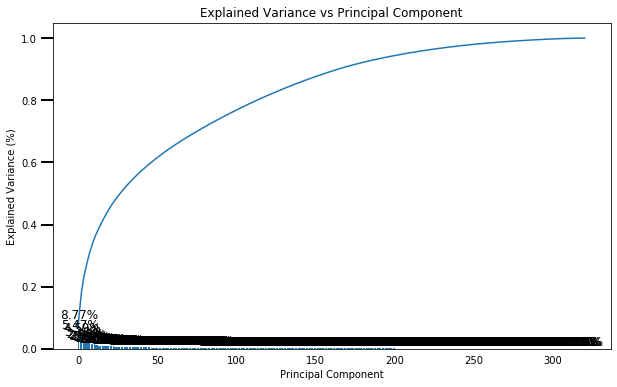

In [120]:
# plot principla component with cumulutive explain varioance 
ut.plot_pca(pca_azdias)

In [14]:
np.cumsum(pca_azdias.explained_variance_ratio_)[149]

0.8748340776121769

In [15]:
np.cumsum(pca_azdias.explained_variance_ratio_)[174]

0.9146155961802027

In [16]:
np.cumsum(pca_azdias.explained_variance_ratio_)[199]

0.9431456580559057

### Observation
Above graph we can conclude that 175 components account for just over 90% of the variance. That means using these 175 components, we cab expain essential characteristics of the data. Therefore, we will retain only 175 components and continue PCA with 175 components


In [8]:
#re-applyig PCA with 175 components
n_components = 175
pca_azdias_175, azdias_reduced_175 = ut.my_pca(azdias,175)

In [ ]:
# applyig PCA with 175 components to customer dataset
n_components = 175
pca_customers_175, customers_reduced_175 = ut.my_pca(customers,175)

### Analyze PCA result and few components

In [124]:
# Generate PCA results
pca_results = ut.pca_results(azdias, pca_azdias_175)

In [125]:
pca_results

,Explained Variance,AKT_DAT_KL,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEG

In [215]:
len(azdias_reduced_175)

785419

###### Analyze first components of  principal components 

In [33]:
variance, weights = ut.features_of_component(pca_azdias_175,0,azdias.columns)
print("Variance of first component:", variance)
print("Top 10 most important features with positive and negative weights:")
print(weights[:10])
print(weights[-10:])

Variance of first component: 9.0
The most five important features with positive weights and the most five important features with negative weights:
                    Weight
PLZ8_ANTG3            0.14
KBA13_ANTG3           0.14
KBA13_ANTG4           0.14
KBA13_BAUMAX          0.14
PLZ8_ANTG4            0.14
PLZ8_BAUMAX           0.14
CAMEO_DEU_2015        0.14
CAMEO_DEUG_2015       0.14
CAMEO_INTL_2015       0.13
HH_EINKOMMEN_SCORE    0.13
                 Weight
KBA05_ANTG1       -0.13
KBA05_GBZ         -0.13
KBA05_AUTOQUOT    -0.13
KBA13_AUTOQUOTE   -0.13
LP_STATUS_GROB    -0.13
MOBI_RASTER       -0.13
MOBI_REGIO        -0.14
LP_STATUS_FEIN    -0.14
KBA13_ANTG1       -0.14
PLZ8_ANTG1        -0.14


###### Analyze second components of  principal components 

In [35]:
variance, weights = ut.features_of_component(pca_azdias_175,1,azdias.columns)
print("Variance of second component:", variance)
print("Top 10 most important features with positive and negative weights:")
print(weights[:10])
print(weights[-10:])

Variance of second component: 5.0
The most five important features with positive weights and the most five important features with negative weights:
                             Weight
KBA13_HERST_BMW_BENZ           0.19
KBA13_MERCEDES                 0.16
KBA13_SEG_OBEREMITTELKLASSE    0.16
KBA13_BMW                      0.16
KBA13_SITZE_4                  0.15
KBA13_SEG_SPORTWAGEN           0.14
KBA13_KMH_211                  0.13
KBA05_HERST1                   0.13
KBA13_KMH_250                  0.13
KBA13_KW_121                   0.13
                         Weight
KBA13_HERST_FORD_OPEL     -0.11
OST_WEST_KZ               -0.11
KBA13_KW_0_60             -0.11
KBA13_HALTER_20           -0.11
KBA13_SEG_KOMPAKTKLASSE   -0.12
KBA13_KMH_180             -0.12
KBA13_HALTER_25           -0.12
KBA13_KMH_140_210         -0.13
KBA13_SEG_KLEINWAGEN      -0.13
KBA13_SITZE_5             -0.15


##### Analyze third components of  principal components 

In [36]:
variance, weights = ut.features_of_component(pca_azdias_175,2,azdias.columns)
print("Variance of third component:", variance)
print("Top 10 most important features with positive and negative weights:")
print(weights[:10])
print(weights[-10:])

Variance of third component: 5.0
The most five important features with positive weights and the most five important features with negative weights:
                       Weight
CJT_TYP_1                0.21
PRAEGENDE_JUGENDJAHRE    0.21
CJT_TYP_2                0.21
FINANZ_SPARER            0.21
FINANZ_UNAUFFAELLIGER    0.19
SEMIO_PFLICHT            0.18
FINANZ_ANLEGER           0.18
SEMIO_TRADV              0.18
SEMIO_REL                0.17
SEMIO_RAT                0.16
                      Weight
RETOURTYP_BK_S         -0.14
SEMIO_LUST             -0.14
CJT_KATALOGNUTZER      -0.15
KOMBIALTER             -0.16
CJT_TYP_6              -0.18
CJT_TYP_3              -0.19
CJT_TYP_4              -0.19
ALTERSKATEGORIE_GROB   -0.19
CJT_TYP_5              -0.19
FINANZ_VORSORGER       -0.20


### Explaination of initial few components
1. Component1 : Component 1 is associated with family size in PLZ/Cell and share of car per households along with CAMEO classification.
2. Component2 : this is associated with type of car in PLZ8 , example upper middle and upper class carrs,  BMW & Mercedes Benz, sportscars and cars with 5 seats 
3. Component3 : deals with financial typology ( like money saver and be prepared) and personal believe/background/mindset(religious, traditional minded or rational minded) and age classification through prename analysis

## Clustering

In this section, you will choose to use different clustering algorith to benchmark performance and then chose one best performing algorith to cluster demographic information for german population and customers of mail company.

We will start with MiniBatchKMeans clustering algorithm (centroid-based models). This is most common clustering algorithm because it is simple, easy to understand and implement. Compare to normal KMeans , miniBatchKmeans is variant of KMeans but take less computation time while attempting to optimize same objective function

Other algorith we will evaluate are few from below list:

- Centroid-based : KMeans 
- Density-based : DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
- Expectation-maximization :  Gaussian Mixture Models (GMM) 
- Connectivity-based, or hierarchical : Hierarchical Clustering Algorithms


### Benchmarking : implementation of MiniBatchKMeans clustering

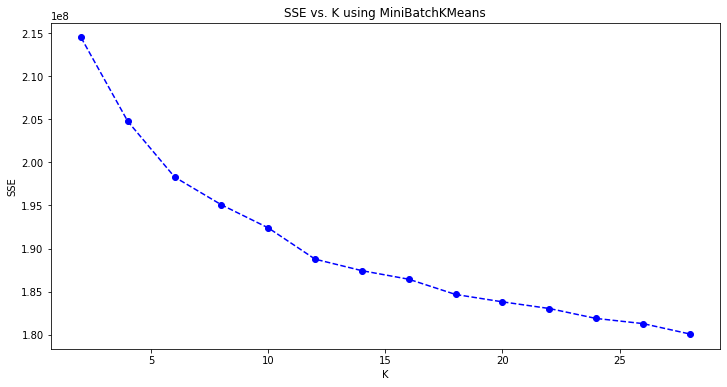

In [78]:
#plot the minikmean score
scores = []
nu_clusters = list(range(2,30, 2))
for nu_cluster in nu_clusters:
    #print(center)
    scores.append(ut.get_minikmeans_score(azdias_pca_175, nu_cluster))
    

plt.figure(figsize=(12,6))
plt.plot(n_clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K using MiniBatchKMeans');   
plt.savefig('elbow_plot_2_30_2.png')

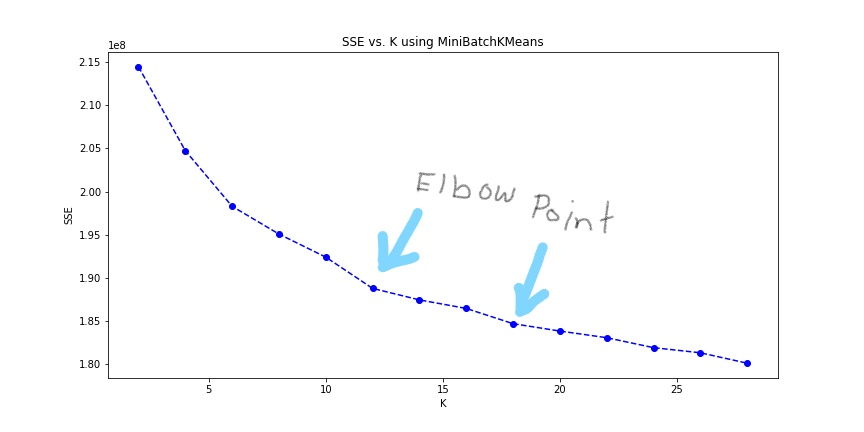

In [133]:
# Have saved version of embow plot since it takes hours to generate

from IPython.display import Image
Image(filename='elbow_plot_2_30_2.png')


### Elbow Method : Observations
Sum of the square Error(SSE) decreases with number of cluster increases. Optimal number of custer is having small number of  SSE and small number of cluster. Thererfore, there is trade-off. Elbow point of the SSE Vs K graph above gives good choice for optimal number of cluster. From above diagram, there seems two elbow points at 12 and 18.

It seems any point bteween 10 to 18 is optimal.

There is a better method of chosing optimal value of number of cluster : **Silhouette Score** and **BIC/AIC Number(for Probalistic algorithm**

We will try silhouette_score in subsequent section

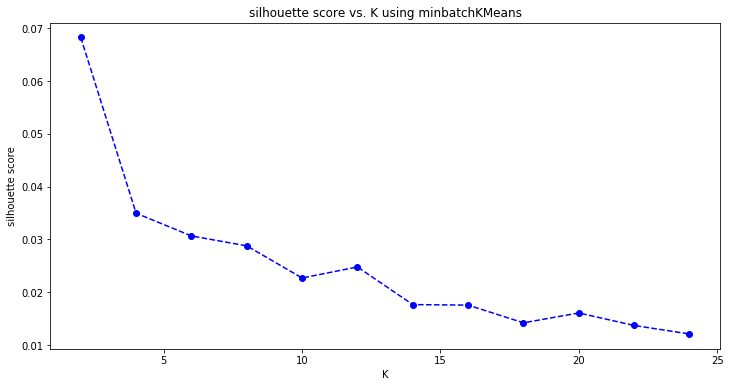

In [141]:
#plot the silhouette_score
s_score= []
nu_clusters = list(range(2,26, 2))
for nu_cluster in nu_clusters:
    
    s_score.append(ut.get_minikmeans_silhouette_score(azdias_reduced_175,nu_cluster,50000,50000))
    

plt.figure(figsize=(12,6))
plt.plot(nu_clusters, s_score, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('silhouette score');
plt.title('silhouette score vs. K using minbatchKMeans');   
plt.savefig('silhouette_plot_4_26_2.png')

In [142]:
pd.DataFrame( data =s_score, columns = ['Silhouette Score'] , index =nu_clusters)

,Silhouette Score
2,0.068278
4,0.034970
6,0.030661
8,0.028782
10,0.022691
12,0.024779
14,0.017648
16,0.017553
18,0.014195
20,0.016060


#### Optimal number of cluster
In elbow method, SSE calculation we only considers only intra cluster distance i.e.mean square distance between each innstance and its centroid. Silhouette Score consider both intra cluster distance and next closest cluster.

From above two method, **most optimal number of clusters is 14**

#### Implementation of KMeans

In [16]:
models=[]
scores = []
silhouette_scores =[]

In [13]:
#instantiat emodels and fit the model
kmeans = KMeans(n_clusters=14, random_state=42)
model = kmeans.fit(azdias_reduced_175)

In [221]:
model.labels_ 

array([ 5,  5,  0, ..., 12,  3,  0])

In [15]:
#calculate Score and Silhouette score for Kmeans model 
score = np.abs(model.score(azdias_reduced_175))
s_score = silhouette_score(azdias_reduced_175, model.labels_,sample_size =50000)

In [17]:
score

186148779.6714602

In [18]:
s_score

0.020756379082351156

In [20]:
# create three list for storing models and corresponding scores
models =['kmeans']
scores =[186148779.6714602]
silhouette_scores = [0.020756379082351156]

#### Implementation of GaussianMixture

In [29]:
GMM = GaussianMixture(n_components=14,random_state=42)
GMM = GMM.fit(azdias_reduced_175)
labels = GMM.predict(azdias_reduced_175)

In [30]:
#calculate Score and Silhouette score for Gaussian mixture model 
score = np.abs(GMM.score(azdias_reduced_175))
s_score = silhouette_score(azdias_reduced_175, labels,sample_size =50000)

In [31]:
score

192.36532511048162

In [32]:
s_score

-0.008622201248077919

**The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar**.

In [ ]:
# create three list for storing models and corresponding scores
models =['kmeans','GMM']
scores =[186148779.6714602,192.36532511048162]
silhouette_scores = [0.020756379082351156, -0.008622201248077919]

#### Implementation of AgglomerativeClustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

In [11]:
 #instantiat AgglomerativeClustering
hierarchical = AgglomerativeClustering(n_clusters=14, affinity='euclidean', linkage='ward')
cluster_labels = hierarchical.fit_predict(azdias_reduced_175)


MemoryError: 

### Conclusion :
AgglomerativeClustering seems not suitable for large data. I am getting **MemoryError**. Comparing KMeans and Gausian Mixture Model, KMeans gives better Silhoutte score. Therefore, for we will use Kmean clusting for rest of the analysis.


### Final Clustering of azdias and customers dataset

We will use KMeans clustering for dataset azdias and customer. Then we will compare their custers

In [20]:
# prediction of azdias dataet
azdias_labels = model.predict(azdias_reduced_175)
#same result can also get from model.labels_

In [219]:
azdias_labels

array([ 5,  5,  0, ..., 12,  3,  0])

In [28]:
len(azdias_labels)

785419

In [24]:
# applyig PCA with 175 components to customer dataset and transform
n_components = 175
pca_customers_175, customers_reduced_175 = ut.my_pca(customers,175)

In [25]:
# prediction of customers dataet
customers_labels = kmeans.fit_predict(customers_reduced_175)

In [26]:
customers_labels

array([ 3,  4,  1, ...,  5,  4, 12])

In [27]:
len(customers_labels)

140371

## Comparision of general population and customers clusters

In [32]:
# find total number of members in each cluster for both general population and customers
azdias_clusters_count = Counter(azdias_labels)
customer_clusters_count = Counter(customers_labels)

In [107]:
#Find percentage representation of each cluster 
azdias_clusters_percentage = [(c, round((azdias_clusters_count[c] / len(azdias_labels) * 100.0),2))
                              for c in azdias_clusters_count]
# sorting by cluster number
azdias_clusters_percentage.sort(key = itemgetter(0))


customer_clusters_percentage = [(c, round((customer_clusters_count[c] / len(customers_labels) * 100.0),2)) 
                              for c in customer_clusters_count]
customer_clusters_percentage.sort(key = itemgetter(0))

In [108]:
x,y1 = zip(*azdias_clusters_percentage)
x,y2 = zip(*customer_clusters_percentage)


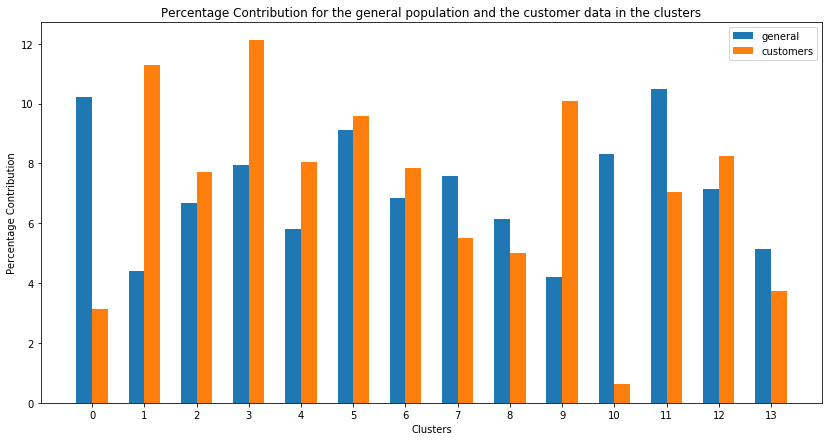

In [124]:
x = np.arange(14)
bar_width = 0.30
fig, ax = plt.subplots( figsize=(14, 7))

ax.bar(x, y1, bar_width, label = "general")
ax.bar((x + bar_width), y2, bar_width, label = "customers")

ax.set_xlabel('Clusters')
ax.set_ylabel('Percentage Contribution')
ax.set_title('Percentage Contribution for the general population and the customer data in the clusters')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(x)
ax.legend()

plt.show();

### Observations: 
1) cluster number 1, 3 and 9 of general population are over-represented by customers

2) Cluster number 0, 10 are under-represented by customers

#### Analyse clusters of general populations that are potential customers for mail-order company

In [125]:
weight_array = pca_azdias_175.components_[1]

In [201]:
_,weights_1 = ut.features_of_component(pca_azdias_175,1,azdias.columns)
_,weights_3 = ut.features_of_component(pca_azdias_175,3,azdias.columns)
_,weights_9 = ut.features_of_component(pca_azdias_175,9,azdias.columns)

In [202]:
print("Top 5 most important features with positive and negative weights of Cluster 1:")
print(weights_1[:5])
print(weights_1[-5:])

Top 5most important features with positive and negative weights of Cluster 1:
                             Weight
KBA13_HERST_BMW_BENZ           0.19
KBA13_MERCEDES                 0.16
KBA13_SEG_OBEREMITTELKLASSE    0.16
KBA13_BMW                      0.16
KBA13_SITZE_4                  0.15
                      Weight
KBA13_KMH_180          -0.12
KBA13_HALTER_25        -0.12
KBA13_KMH_140_210      -0.13
KBA13_SEG_KLEINWAGEN   -0.13
KBA13_SITZE_5          -0.15


In [ ]:
KBA13_HERST_FORD_OPEL     -0.11
OST_WEST_KZ               -0.11
KBA13_KW_0_60             -0.11
KBA13_HALTER_20           -0.11
KBA13_SEG_KOMPAKTKLASSE   -0.12
KBA13_KMH_180             -0.12
KBA13_HALTER_25           -0.12
KBA13_KMH_140_210         -0.13
KBA13_SEG_KLEINWAGEN      -0.13
KBA13_SITZE_5             -0.15

In [208]:
# Top 10 most important features of cluster1
Cluster_1_imp_features = (weights_1[:5].index).union(weights_1[-5:].index)

In [146]:
print("Top 5 most important features with positive and negative weights of Cluster 3:")
print(weights_3[:5])
print(weights_3[-5:])

Top 5 most important features with positive and negative weights of Cluster 3:
                     Weight
LP_FAMILIE_GROB        0.17
LP_LEBENSPHASE_GROB    0.17
LP_LEBENSPHASE_FEIN    0.16
LP_FAMILIE_FEIN        0.16
ANZ_PERSONEN           0.16
                   Weight
W_KEIT_KIND_HH      -0.11
D19_KONSUMTYP_MAX   -0.17
VK_ZG11             -0.18
VK_DHT4A            -0.19
VK_DISTANZ          -0.20


In [210]:
# Top 10 most important features of cluster3
Cluster_3_imp_features = (weights_3[:5].index).union(weights_3[-5:].index)

In [147]:
print("Top 10 most important features with positive and negative weights of Cluster 9:")
print(weights_9[:5])
print(weights_9[-5:])

Top 10 most important features with positive and negative weights of Cluster 9:
                      Weight
KBA13_ALTERHALTER_45    0.16
KBA13_HALTER_40         0.16
KBA13_KMH_140_210       0.16
KBA13_HERST_AUDI_VW     0.15
KBA13_VW                0.14
                  Weight
PLZ8_GBZ           -0.14
KBA13_GBZ          -0.14
KBA13_HHZ          -0.16
PLZ8_HHZ           -0.16
KBA13_ANZAHL_PKW   -0.19


In [212]:
# Top 10 most important features of cluster9
Cluster_9_imp_features = (weights_9[:5].index).union(weights_9[-5:].index)

In [224]:
#loading azdias cleaned unscalled data from picle file
file = open("azdias_final.pickle", "rb")
azdias_original_cleaned = pickle.load(file)
file.close()

In [225]:
azdias_original_cleaned.shape

(785419, 321)

In [226]:
# Add cluster Label as separate columns in the population dataset 
azdias_original_cleaned['Cluster'] = azdias_labels

In [227]:
azdias_original_cleaned.shape

(785419, 322)

In [273]:
# calculate two top values of feature for particular cluster
# filter by Cluster number and feature name. Then find value count , take first two values of value count.
# Then print only value ( by index.values)
print ("Top two values for top feature in the cluster 1:")
for feature in Cluster_1_imp_features:
    x= azdias_original_cleaned[feature][azdias_original_cleaned['Cluster']==1].value_counts().index.values[0:2]
    print ("{} : {}".format(feature,x))

Top two values for top feature in the cluster:
KBA13_BMW : [2. 3.]
KBA13_HALTER_25 : [4. 5.]
KBA13_HERST_BMW_BENZ : [2. 1.]
KBA13_KMH_140_210 : [3. 4.]
KBA13_KMH_180 : [3. 4.]
KBA13_MERCEDES : [2. 1.]
KBA13_SEG_KLEINWAGEN : [4. 3.]
KBA13_SEG_OBEREMITTELKLASSE : [2. 1.]
KBA13_SITZE_4 : [2. 1.]
KBA13_SITZE_5 : [5. 4.]


In [274]:
# calculate two top values of feature for particular cluster
# filter by Cluster number and feature name. Then find value count , take first two values of value count.
# Then print only value ( by index.values)
print ("Top two values for top feature in the cluster 3:")
for feature in Cluster_3_imp_features:
    x= azdias_original_cleaned[feature][azdias_original_cleaned['Cluster']==1].value_counts().index.values[0:2]
    print ("{} : {}".format(feature,x))

Top two values for top feature in the cluster 3:
ANZ_PERSONEN : [1. 2.]
D19_KONSUMTYP_MAX : [8. 9.]
LP_FAMILIE_FEIN : [1. 2.]
LP_FAMILIE_GROB : [1. 2.]
LP_LEBENSPHASE_FEIN : [6. 5.]
LP_LEBENSPHASE_GROB : [2. 4.]
VK_DHT4A : [10.  7.]
VK_DISTANZ : [8. 7.]
VK_ZG11 : [5. 2.]
W_KEIT_KIND_HH : [6. 4.]


In [275]:
# calculate two top values of feature for particular cluster
# filter by Cluster number and feature name. Then find value count , take first two values of value count.
# Then print only value ( by index.values)
print ("Top two values for top feature in the cluster 9:")
for feature in Cluster_9_imp_features:
    x= azdias_original_cleaned[feature][azdias_original_cleaned['Cluster']==1].value_counts().index.values[0:2]
    print ("{} : {}".format(feature,x))

Top two values for top feature in the cluster 9:
KBA13_ALTERHALTER_45 : [1. 3.]
KBA13_ANZAHL_PKW : [1400.  412.]
KBA13_GBZ : [3. 2.]
KBA13_HALTER_40 : [3. 1.]
KBA13_HERST_AUDI_VW : [2. 1.]
KBA13_HHZ : [3. 4.]
KBA13_KMH_140_210 : [3. 4.]
KBA13_VW : [2. 3.]
PLZ8_GBZ : [3. 2.]
PLZ8_HHZ : [3. 4.]


### Conclusion: 
Following section of german population mostly likely represents customers of the mail order company
1. People of family type - single or couple, with very low likelyhood of having children
2. People are of single low income or average earner
3. They stay in the area with average population density
4. Share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.) is low /average
5. Number of adult persons in the household is 1 or 2
6. People are of relatively younder age and tendency to buy high speed car.

# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [314]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [285]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [315]:
mailout_train.shape

(42962, 367)

In [316]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

##### Comments : 
Positive class consist of only 1.25% of  data i.e. 532 of 42430. This is the perfect case of **imbalance data problem**

###  Cleaning and Proprocessing of "MAILOUT" dataset

In [317]:
# cleaning noisy feature and replacing 'XX'/'X' value with np.nan
mailout_train =  clean_feature(mailout_train, columns_to_delete , columns_xx , columns_x)

In [299]:
#around 45 number of features are deleted
mailout_train.shape

(42962, 322)

In [34]:
columns_lbl_encod = ['CAMEO_DEU_2015']

In [324]:
# Cleaning up rows with more than 100 missing values and encoding categorical data
mailout_train = clean_encode_row(mailout_train,100, columns_lbl_encod)

In [326]:
mailout_train.shape

(35000, 322)

#### Impute remaining missing values for numerical and categorical data

In [334]:
len(categorical_col),len(numerical_col), len(mailout_train.columns)

(315, 7, 322)

In [35]:
# as there is no extra columns like customers data
columns_extra = []

In [338]:
# imputing remaining NaN value
mailout_train_final = impute_data(mailout_train,categorical_col, numerical_col, columns_extra)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [97]:
"""
# dump the mailout_train_final dataframe to pickle object to preserve work so far
file = open("mailout_train_final.pickle", "wb")
pickle.dump(mailout_train_final,file)
file.close()

"""

"""

# reload the mailout_train_final dataframe to pickle object to preserve work so far
file = open("mailout_train_final.pickle", "rb")
mailout_train_final= pickle.load(file)
file.close()

"""

In [98]:
# split features and target variable 
y_train = mailout_train_final["RESPONSE"]
x_train = mailout_train_final.drop( columns = ["RESPONSE"], axis = 1)  

In [99]:
x_train.shape, y_train.shape

((35000, 321), (35000,))

In [100]:
#applying feature scalling for the dataset
scaler = preprocessing.StandardScaler()
x_train= pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)

In [365]:
x_train.head()

,AKT_DAT_KL,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,MIN_GEBAEUDEJAHR,GEBURTSJAHR,KBA13_ANZAHL_PKW
0,-0.298757,-0.225278,0.477517,-0.047879,0.336669,0.007259,0.014924,0.081437,-0.573457,0.851741,...,0.204350,0.852961,0.586950,0.555185,-0.131472,-0.751147,-0.091728,-0.354366,-1.559449,-0.681939
1,1.437243,-0.225278,-0.370910,-1.013174,0.336669,-0.157763,0.014924,-0.059859,-0.573457,-1.182394,...,-1.432694,0.852961,-0.644365,-0.378700,-0.131472,-0.016211,-0.091728,0.512448,0.651157,-0.103028
2,-0.298757,-0.225278,-0.370910,0.917417,-1.486050,-1.065380,-1.226781,-1.331529,0.746048,0.851741,...,0.204350,-1.172387,0.586950,-0.445406,-0.131472,-1.486084,-0.091728,0.945856,0.619529,-0.956626
3,-0.298757,-0.225278,-0.158803,0.917417,-1.030370,-1.065380,-1.226781,-1.331529,-0.573457,0.851741,...,0.204350,0.852961,0.586950,-0.178582,-0.131472,-0.016211,-0.091728,-0.354366,0.613881,-0.732151
4,-0.298757,-0.225278,2.669284,-0.047879,-0.119011,0.832365,0.842727,0.575976,2.065554,0.851741,...,0.204350,-1.172387,-0.644365,3.090013,-0.131472,-0.751147,-0.091728,-0.354366,0.627436,-0.992070


### Performance Metrics

As we have seen positive class consist of 1.25% of data, this is case of **imbalance data problem**. Standard accuracy is not a reliably measures for performance evalution of imbalance class. For this kind of problem, we recommend Area Under ROC Curve (AUROC).

Ref : 
1. https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba
2. https://www.dataquest.io/blog/learning-curves-machine-learning/  

### Evaluation of models

We will evaluate few models using learning curve and will choose best model based on AUROC. We will select a Random Forest, few Ensemble classifiers which are insensitive to imbalance data( like cost-sensitive learning) and a SVM model

In [433]:
# choosing fews possible model for evaluation
models = {'RandomForestClassifier': RandomForestClassifier(random_state=42), 
          'AdaBoostClassifier': AdaBoostClassifier(random_state=42), 
          'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
           'SVC' : SVC(random_state=42)
         }

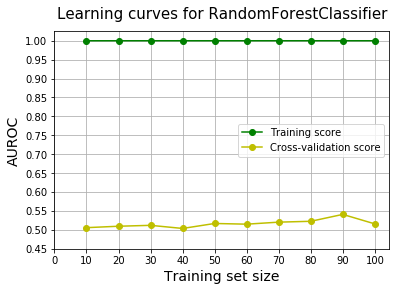

Roc_auc train score = 1.0
Roc_auc validation score = 0.52



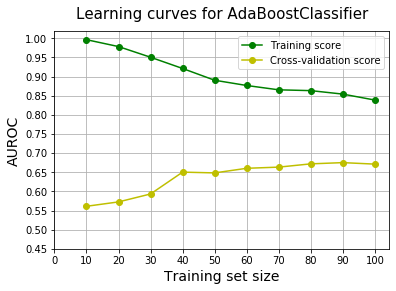

Roc_auc train score = 0.84
Roc_auc validation score = 0.67



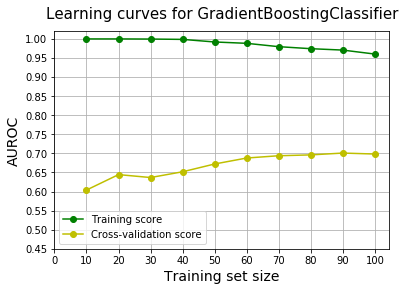

Roc_auc train score = 0.96
Roc_auc validation score = 0.7



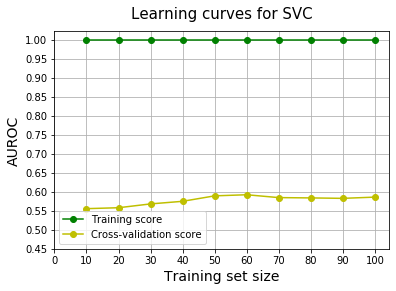

Roc_auc train score = 1.0
Roc_auc validation score = 0.59


In [434]:
# Drawing learnimg curve for AUROC for trainig and validation set for each model
for key in models.keys():
    ut.draw_learning_curves(models[key],x_train,y_train, 10)
   

### Analyse results from model evaluation
1. RandomForestClassifier - AUROC for training set is 1 and validation set in 0.52. Validation has more error. This is case of overfitting. Model is highly biased.

2. AdaBoostClassifier : AUROC for training is 0.84 and validation is 0.67. Both the curve has converged well. This is relatively better model than RandomForestClassifier.

3. GradientBoostingClassifier : AUROC for trainig is 0.96 and validatio is 0.7. Both the curve has not fully converged.This model has highest ROC for both training and validation. This model takes more execution time than AdaBoostClassifier.

4. SVC : AUROC for training is 1 and validation is 0.59. Validation has more error. This is case of overfitting. Model is highly biased. This model has highest execution time . This is worst performing model.

AdaBoostClassifier and GradientBoostingClassifier has almost similar AUROC for validation set. But learning curve for AdaBoostClassifier merges better than GradientBoostingClassifier and has less execution time.

Therefore, **final model we chose for classification is AdaBoostClassifier**. In subsequent section we will choose best hyperparameters for AdaBoostClassifier using Grid Search


### Further optimising Hyperparameters for the best model

In [101]:
# Optimize the AdaBoostClassifier using GridSearchCV

param_grid = {'algorithm': ['SAMME.R'],
             'learning_rate': [0.5, 1.0, 1.5],
             'n_estimators': [20, 50, 100]}

grid_obj = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='roc_auc')
grid_obj.fit(x_train, y_train)

best_clf = grid_obj.best_estimator_

print(grid_obj.best_score_)
print(best_clf)

0.7048685826428918
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=20, random_state=None)


#####  With hyperparameters tuning validation score has improved from 67% to 70.5% 

In [102]:
# dump the best model  into pickle object for later resue
file = open("best_clf.pickle", "wb")
pickle.dump(best_clf,file)
file.close()

### Possible Further Improvements of model and data handling
Apart from what achieved above, there could be other possible improvement for handling imbalance class classification problem:

1. Random undersampling of the majority class
2. Random oversampling of the minority class
3. Random undersampling may leads to potential loss of information  as lot of data instances are removed. In this case we can perform a informed undersampling by finding out the distribution of data first and selectively removing majority class.
4. **SMOTE**: Synthetic Minority Over-sampling Technique has been designed to generate new samples that are coherent with the minor class distribution. The main idea is to oversample with synthetically generated data points that are not too different from the minority class data

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [12]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [13]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [14]:
mailout_test.shape

(42833, 366)

#### Delete features not required
To reduce unncessary data noise we will delete the feature stored into list 'columns_to_delete'. These are same set of columns we have deleted for all three datasets so far.

In case of mailout_test we retain the columns "LNR" as this is required to send for Kaggle competition

In [30]:
# delete "LNR" from the list of columns to be deleted "columns_to_delete"
columns_to_delete.remove('LNR')

In [31]:
len(columns_to_delete)

44

In [41]:
# cleaning noisy feature and replacing 'XX'/'X' value with np.nan
mailout_test =  clean_feature(mailout_test, columns_to_delete , columns_xx , columns_x)

In [42]:
# 44 number of features are removed except "LNR"
mailout_test.shape

(42833, 322)

In [45]:
#missing values for each rows
rows_nan_mail= mailout_test.shape[1]- mailout_test.count(axis = 1)

# Descrptive stat for missing value for rows
rows_nan_mail.describe()

count    42833.000000
mean        43.539654
std         88.212986
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        242.000000
dtype: float64

In [74]:
# checing null value for "LNR"
mailout_test["LNR"].isnull().sum()

0

In [66]:
columns_lbl_encod

['CAMEO_DEU_2015']

#### Purpose of this section of analysis is to measure of how likely each individual became a customer. We shall try to capture as many of the actual customers as possible early in the ROC curve sweep.
### Therefore, we will not delete a single data row irrespective of number of nan value it has.

In [69]:
# Deleting no rows missing values and encoding categorical data
# missing number of NaN per row is set 1000 i.e. no row will be deleted
mailout_test = clean_encode_row(mailout_test,1000, columns_lbl_encod)

In [81]:
mailout_test.shape

(42833, 322)

In [85]:
mailout_test_LNR = mailout_test["LNR"]

In [70]:
# as there is no extra columns like customers data
columns_extra = []

# imputing remaining NaN value
# This will also remove "LNR" columns 
mailout_test_final = impute_data(mailout_test,categorical_col, numerical_col, columns_extra)

In [87]:
#applying feature scalling for to mailout_test_final dataset
scaler = preprocessing.StandardScaler()
mailout_test_scaled = pd.DataFrame(scaler.fit_transform(mailout_test_final), columns = mailout_test_final.columns)

In [90]:
mailout_test_scaled.shape

(42833, 321)

In [93]:
mailout_test_scaled.head()

,AKT_DAT_KL,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,MIN_GEBAEUDEJAHR,GEBURTSJAHR,KBA13_ANZAHL_PKW
0,-0.271646,-0.206929,-0.262286,-0.211076,0.674524,-1.352721,-1.419477,-1.378835,0.968505,0.760581,...,0.178441,-1.213276,0.728696,-0.287584,-0.120872,-0.015838,-0.088595,0.121473,-1.198264,-0.641528
1,-0.271646,-0.206929,1.211049,0.774537,1.153740,-0.501141,-0.069416,-0.019820,-1.310239,0.760581,...,0.178441,-1.213276,0.728696,1.038302,-0.120872,-0.819601,-0.088595,-0.318161,-1.198264,1.089877
2,4.719141,-0.206929,-0.262286,0.774537,-1.721553,0.350440,0.830625,0.735189,-0.740553,0.760581,...,0.178441,0.824215,0.728696,-0.287584,-0.120872,1.591688,-0.088595,-0.318161,0.832076,0.288730
3,3.471445,-0.206929,-0.339830,0.774537,-1.721553,-1.352721,-1.419477,-1.378835,0.398819,0.760581,...,0.178441,0.824215,0.728696,-0.361244,-0.120872,-1.623364,-0.088595,-0.318161,-1.198264,-0.926234
4,-0.271646,-0.206929,-0.339830,-0.211076,0.674524,-0.501141,-0.069416,-0.019820,1.538191,-2.003016,...,1.070811,0.824215,0.728696,-0.361244,-0.120872,1.591688,-0.088595,-0.318161,0.842509,-1.561855


In [103]:
# Calculate prediction probabilities for the test set and print the first 10 results
preds = best_clf.predict_proba(mailout_test_scaled)

In [121]:
preds[0:10]

array([[0.60436535, 0.39563465],
       [0.60525495, 0.39474505],
       [0.63144999, 0.36855001],
       [0.64795754, 0.35204246],
       [0.61944271, 0.38055729],
       [0.6394229 , 0.3605771 ],
       [0.61505003, 0.38494997],
       [0.61697237, 0.38302763],
       [0.62725218, 0.37274782],
       [0.61805349, 0.38194651]])

In [125]:
# creat dataframe for kaggle with LNR and RESPONSE probability
kaggle = pd.DataFrame({ "LNR" : mailout_test_LNR, "RESPONSE" : preds[:,1] })

In [126]:
kaggle.head()

,LNR,RESPONSE
0,1754,0.395635
1,1770,0.394745
2,1465,0.368550
3,1470,0.352042
4,1478,0.380557


In [127]:
#create CSV in local system out of LNR and RESPONSE
kaggle.to_csv("kaggle.csv",index=False)